# Notebook to filter the tracks exported from TrackMate and measure the mean intensity of cells detected in a timeseries image of Suprachiasmatic Nuclei (SCN)

This notebook was created to select the 'good tracks' from the tracks identified by TrackMate and measure the mean intensity of each ROI (cell) detected in the SNC. TrackMate occasionally identifies short tracks, i.e. cells that were detected just for a few time points, which are not useful for the circadian analysis (CIRCADIA.app) and will be removed by the code in this notebook. 
In addition, the code will measure the mean intensity of the whole, left, and right sides of the image, and export these measurements in a .csv file.

In [ ]:
# Import the packages needed to run the notebook
import numpy
import skimage
import skimage.io
import pandas
import scipy.ndimage
import matplotlib.pyplot as plt
import os

# Choose the Input and Output folders

The input folder must contain:
1. moviename_processed.tif - movie after noise removal; this file would be used for measuring cell intensities
2. moviename_lblImg.tif - movie with the centroids of the cells detected; this file will be used to detect the cells for which measurements will be made
3. moviename.csv - file containing the track information; this file will be used as a track reference for the intensity measurements
- These files were generated by running the ```SNC_Cell_Detection_Tracking.py``` code in Fiji

The output folder is where you save the .csv files generated by this code, which will be the following:
1. Beforefilter_moviename.csv - contain all tracks detected in trackmate
2. Afterfilter_moviename.csv contain only the good tracks kept after filtering by this code
3. complete_moviename.csv contain the good tracks (cells/events), and mean intensity measurements

In [ ]:
#Choose the folders

# This can be the output folder from the FiJi/TrackMate code
input_folder = '/Volumes/BAGGINS/TRD2_Harrington_Data/DBPHarrington/Results/downsampled_output'
# Folder were graphs and created files will be stored
output_folder = '/Volumes/BAGGINS/TRD2_Harrington_Data/DBPHarrington/Results/downsampled_output_filtered'

# Filtering the tracks and measuring intensities of cells detected in each track

1. Set the hyperparameters to determine whether a detected track is a 'good track'. This will depend on your dataset and research question
2. Sort the events based on tracks and frame numbers
3. Save the x and y positions of the start and end of the tracks for each event
4. Filter out tracks with just 1 frame
5. Add ROI in the same x and y positions at the start and end of the track even_ext number of frames
6. Add ROI in the x,y position in the missing frame where the previous frame ROI was
7. Dilate ROI to pixel_size of event 
8. Measurement of cell mean intensity for all tracks detected using Trackmate
9. Filter good tracks (min number of event_frames to be considered eg. 300 frames movie, we just wanna consider the cells detected/track in at least 150 frames)
10. Measurement of cell mean intensity for all good tracks
11. Measure the mean intensity of the entire, left and right side of the image
12. Save mean intensity of good tracks (cells/events), entire, left and right side of the image in the output folder with the name: complete_moviename.csv to be used on CIRCADIA
13. Plot good tracks

In [76]:
# 1. Set the hyperparameters

max_event_frame = 500 # number of maximum event present at a single frame 
min_event_frames_for_good = 60 # minimum number of frames to consider as a good cell
event_ext = 0 #number of frame to extend the event for peak and baseline detection
pixel_size = 11 #pixel size of the events (cell size)

In [73]:
# Optional - clean any ._ files
    # Mac sometimes creates ._ files that contain file-related metadata when transferring files from a macOS system to a non-Mac system
    # These get identified while building the file_list, and can generate warning/error messages
    # This optional step removes any ._ files in the input folder to avoid such warning/error messages

file_list = os.listdir(input_folder)

for file in file_list:
        if file.startswith('._'):
            file_path = os.path.join(input_folder, file)
            try:
                os.remove(file_path)
                print(f"Removed: {file}")
            except Exception as e:
                print(f"Error removing {file_path}: {e}")

(100, 512, 512)


/Users/sdasgupt/anaconda3/envs/TRD2_protocols/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:805: RuntimeWarning: invalid value encountered in divide
  return sum / np.asanyarray(count).astype(np.float64)
/Users/sdasgupt/anaconda3/envs/TRD2_protocols/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:805: RuntimeWarning: invalid value encountered in divide
  return sum / np.asanyarray(count).astype(np.float64)
/Users/sdasgupt/anaconda3/envs/TRD2_protocols/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:805: RuntimeWarning: invalid value encountered in divide
  return sum / np.asanyarray(count).astype(np.float64)
/Users/sdasgupt/anaconda3/envs/TRD2_protocols/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:805: RuntimeWarning: invalid value encountered in divide
  return sum / np.asanyarray(count).astype(np.float64)
/Users/sdasgupt/anaconda3/envs/TRD2_protocols/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:805: RuntimeWarning: i

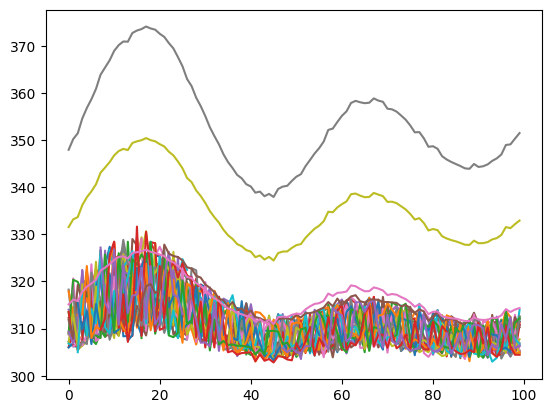

In [79]:
# Reading the files

file_list = os.listdir(input_folder)

for file in file_list:
    if file[-4:]==".csv":
        movie = file.split(".")[0]
        
        #track_csv contains the x,y,z position of the detected events
        tracks_csv = pandas.read_csv(os.path.join(input_folder,movie+'.csv'))

        #label_image is the image sequence with event anotations
        label_image = skimage.io.imread(os.path.join(input_folder,movie+'_lblImg.tif'))
        
        #raw_image is the raw movie
        raw_image = skimage.io.imread(os.path.join(input_folder,movie+'_processed.tif'))
        
        length = raw_image.shape[0]
        print(raw_image.shape)

        R,C,J= raw_image.shape
        C = int(C/2)

        raw_image_left = raw_image[:,:C,:]
        raw_image_right = raw_image[:,C:,:]

        
        # 2. Sort event ROI based on event number and frame number
        tracks_csv=tracks_csv.where(tracks_csv.notnull(), None)
        tracks_csv = tracks_csv.sort_values(by=['TRACK_ID', 'FRAME'])
        tracks_csv['TRACK_ID'] = tracks_csv['TRACK_ID'] + 1
        tracks_csv['FRAME'] = tracks_csv['FRAME'] + 1

        # Filter events around cell movements
        tracks = tracks_csv.groupby("FRAME").agg(**{"TRACK_COUNT": pandas.NamedAgg(column='TRACK_ID', aggfunc="nunique"),
                                  "TRACK_LIST": pandas.NamedAgg(column='TRACK_ID', aggfunc="unique")})
      
        #tracks_length = tracks_csv.groupby("TRACK_ID").agg(**{"FRAME_COUNT": pandas.NamedAgg(column='FRAME', aggfunc="nunique")})

        multi_tracks = tracks.drop(tracks[tracks.TRACK_COUNT <= max_event_frame ].index)
        multi_tracks = multi_tracks.explode('TRACK_LIST')
        multi_tracks_list = multi_tracks.TRACK_LIST.unique()
        bad_tracks = multi_tracks_list.tolist()

        
        # 3. Save the x,y position at the start and end of the track for each event
        track_dic = {}
        for index,row in tracks_csv.iterrows():
            if row["TRACK_ID"] != None:
                if row["TRACK_ID"] not in bad_tracks:
                    track_id = int(row["TRACK_ID"])
                    if track_id not in list(track_dic.keys()):
                        track_dic[track_id] = {}
                        track_dic[track_id]["start_frame"] = track_dic[track_id]["stop_frame"] = row["FRAME"]
                        track_dic[track_id]["start_x"] = track_dic[track_id]["stop_x"] = row["POSITION_X"]
                        track_dic[track_id]["start_y"] = track_dic[track_id]["stop_y"] = row["POSITION_Y"]
                    else:
                        track_dic[track_id]["stop_frame"] = row["FRAME"]
                        track_dic[track_id]["stop_x"] = row["POSITION_X"]
                        track_dic[track_id]["stop_y"] = row["POSITION_Y"]
        track_list=list(track_dic.keys())

        

        # 4. Filter tracks that are just 1 frame
        for track in track_list:
            if int(track_dic[track]["stop_frame"])-int(track_dic[track]["start_frame"]) < 1:
                del track_dic[track]
        track_list=list(track_dic.keys())



        # 5. For each track, the code extends its label from the start frame backwards and from the stop frame forwards by a certain number of frames (event_ext).
            # This ensures that ROIs are consistently labeled across a wider range of frames
        
        for track in track_list:
            start = int(track_dic[track]["start_frame"])
            stop = int(track_dic[track]["stop_frame"])
            for x in range(1, event_ext):
                if start-x > 0:
                    label_image[start-x] = numpy.where(label_image[start] == track, track, label_image[start-x])
            for x in range(1, event_ext):
                if stop+x < length:
                    label_image[stop+x] = numpy.where(label_image[stop] == track, track, label_image[stop+x])

        
        
        # 6. Add ROI in the x,y position in the missing frame where the previous frame ROI was
        for track in track_list:
            start = int(track_dic[track]["start_frame"])-event_ext
            stop = int(track_dic[track]["stop_frame"])+event_ext+1
            if start <= 0:
                start = 1
            else:
                start = start
            if stop > length:
                stop = length
            else:
                stop = stop

            for frame in range(start,stop,1):
                if track not in label_image[frame]:
                    label_image[frame] = numpy.where(label_image[frame-1] == track, track, label_image[frame])

        
        #7. Dilate ROI to pixel_size of event 
        for frame in range(length):
            A = label_image[frame]
            B = scipy.ndimage.maximum_filter(A, pixel_size)
            B[A != 0] = A[A != 0]
            label_image[frame] = B

        
        
        # 8. Save measurement of event before filtering                
        track_df = pandas.DataFrame(index=track_list)
        for frame in range(length):
            track_df[frame]=scipy.ndimage.mean(raw_image[frame,:,0],labels=label_image[frame],index=track_list)    
        track_df=track_df.T
        track_df["timepoint"]=track_df.index        
        track_df.dropna(axis='columns', how='all', inplace=True)        
        track_df.to_csv(os.path.join(output_folder,'Beforefilter'+movie+'.csv'))


        # 9. Filter good cells/tracks, here you can choose the minimum number of frames the cell apeer to be considered a good track
        list_good = []
        
        for track in track_list:
            start = int(track_dic[track]["start_frame"])
            stop = int(track_dic[track]["stop_frame"])
            distance = stop - start 
            if distance > min_event_frames_for_good:
                good_tracks = track
                list_good.append(good_tracks)
                
        

        track_df = pandas.DataFrame(index=list_good)

        track_df_filter = track_df[track_df.index.isin(list_good)]
       
        # 10. Measure the mean intensity of good tracks
        for frame in range(length):
            track_df[frame]=scipy.ndimage.mean(raw_image[frame,:,0],labels=label_image[frame],index=list_good)    
        track_df=track_df.T       
        track_df.dropna(axis='columns', how='all', inplace=True)        
        track_df.to_csv(os.path.join(output_folder,'Afterfilter'+movie+'.csv'))

        # 11. Measure the mean intensity of the entire, left and right side of the image
        y = []
        y1 = []
        y2 = []
        for i in range(raw_image_left.shape[0]):
            y.append(raw_image_left[i,:,:].mean())
            

        for i in range(raw_image_right.shape[0]):
            y1.append(raw_image_right[i,:,:].mean())
            

        for i in range(raw_image.shape[0]):
            y2.append(raw_image[i,:,:].mean())
        
        y_df = pandas.DataFrame(y)
        y1_df = pandas.DataFrame(y1)
        y2_df = pandas.DataFrame(y2)

        track_df['left'] = y_df
        track_df['right'] = y1_df
        track_df['whole'] = y2_df

        # 12. Save mean intensity of good tracks (cells/events), entire, left and right side of the image in the output folder with the name: complete_moviename.csv to be used on CIRCADIA
        track_df.to_csv(os.path.join(output_folder,'complete_'+movie+'.csv'))

        # 13. Plot good tracks

        track_df.plot.line(legend=False)
